In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

###### predict date range ######
# pd.date_range(start="2021-12-26",end="2022-01-01")
# pd.date_range(start="2022-01-23",end="2022-01-29")

In [8]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [9]:
fe1 = pd.read_csv('지면온도,강설량.csv',encoding='cp949') # 00시 데이터 없음
fe2 = pd.read_csv('sunset_sunrise_data.csv')

In [35]:
fe1.head()

,지점,지점명,일시,강수량(mm),강수량 QC플래그,적설(cm),3시간신적설(cm),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,192,진주,2021-11-26 01:00,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,192,진주,2021-11-26 02:00,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN
2,192,진주,2021-11-26 03:00,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN
3,192,진주,2021-11-26 04:00,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN
4,192,진주,2021-11-26 05:00,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN


In [10]:
# 시간 붙이기
fe2['년월일'] = fe2.iloc[:,0].apply(lambda x:pd.to_datetime(str(x),format='%Y%m%d').strftime(format='%Y-%m-%d')+' 00:00:00')
fe2.head()

,Unnamed: 0,sunrise,sunset,년월일
0,20211126,713,1717,2021-11-26 00:00:00
1,20211127,714,1716,2021-11-27 00:00:00
2,20211128,715,1716,2021-11-28 00:00:00
3,20211129,716,1716,2021-11-29 00:00:00
4,20211130,717,1716,2021-11-30 00:00:00


In [12]:
df0 = pd.read_csv('smart_farm_train_nonull.csv')
df0 = pd.merge(df0,fe2.iloc[:,1:],on='년월일',how='left')
df = df0.set_index('시간')
df = df.iloc[:,7:]
train_x = df[df.columns.difference(['열공급량(kWh)'])]
train_y = df[['열공급량(kWh)']]
train_x.head()

,sunrise,sunset,난방온도(설정온도),내부 습도,내부 온도,배기팬,에너지스크린(수직),에너지스크린(수평),외기습도(%),외기온(℃),유동팬,차광스크린(수평),차열스크린(수평),천창,팬코일 B동,풍속(m/s),풍향(º),환기온도(천창 제어온도)
시간,,,,,,,,,,,,,,,,,,
2021-11-26 00:00:00,713,1717,18.0,62.0,18.3,0.0,0.0,0.0,67,5.8,1.0,0.0,0.0,0.0,0.0,0.0,325,28.0
2021-11-26 00:01:00,713,1717,18.0,63.4,18.1,0.0,0.0,0.0,67,5.8,1.0,0.0,0.0,0.0,0.0,0.4,344,28.0
2021-11-26 00:02:00,713,1717,18.0,65.2,17.7,0.0,0.0,0.0,67,5.7,1.0,0.0,0.0,0.0,1.0,0.9,105,28.0
2021-11-26 00:03:00,713,1717,18.0,63.9,17.7,0.0,0.0,0.0,67,5.7,1.0,0.0,0.0,0.0,1.0,1.3,123,28.0
2021-11-26 00:04:00,713,1717,18.0,64.7,17.6,0.0,0.0,0.0,67,5.7,1.0,0.0,0.0,0.0,1.0,0.9,123,28.0


In [13]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(train_x.iloc[:37070]) 
Y_data = Y_scaler.fit_transform(train_y.iloc[:37070])

In [14]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [15]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

# row : min -> 분단위 예측~
hist_window = 60
horizon = 10
TRAIN_SPLIT = 30000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 


In [17]:
batch_size = 128
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [30]:
lstm_model = tf.keras.models.Sequential([
    Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train.shape[-2:]),
    Dense(128, activation='tanh'),
    Bidirectional(tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dropout(0.4),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    Dense(units=horizon),
])
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 60, 400)          350400    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 60, 128)           51328     
                                                                 
 bidirectional_9 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 400)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               51328     
                                                                 
 dense_18 (Dense)            (None, 128)              

In [31]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=20,verbose=1,callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 22s 190ms/step - loss: 0.7767 - rmse: 0.8813 - val_loss: 0.2488 - val_rmse: 0.4988
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 0.2857 - rmse: 0.5345 - val_loss: 0.2918 - val_rmse: 0.5401
Epoch 3/100
100/100 [==============================] - 19s 190ms/step - loss: 0.2384 - rmse: 0.4882 - val_loss: 0.2090 - val_rmse: 0.4572
Epoch 4/100
100/100 [==============================] - 18s 182ms/step - loss: 0.1939 - rmse: 0.4403 - val_loss: 0.1213 - val_rmse: 0.3483
Epoch 5/100
100/100 [==============================] - 18s 182ms/step - loss: 0.1349 - rmse: 0.3673 - val_loss: 0.0276 - val_rmse: 0.1662
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 0.0887 - rmse: 0.2978 - val_loss: 0.0498 - val_rmse: 0.2231
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 0.0778 - rmse: 0.2790 - val_loss: 0.0095 - val_rmse: 0.0976
Epoch 8/100
100/100 [=============

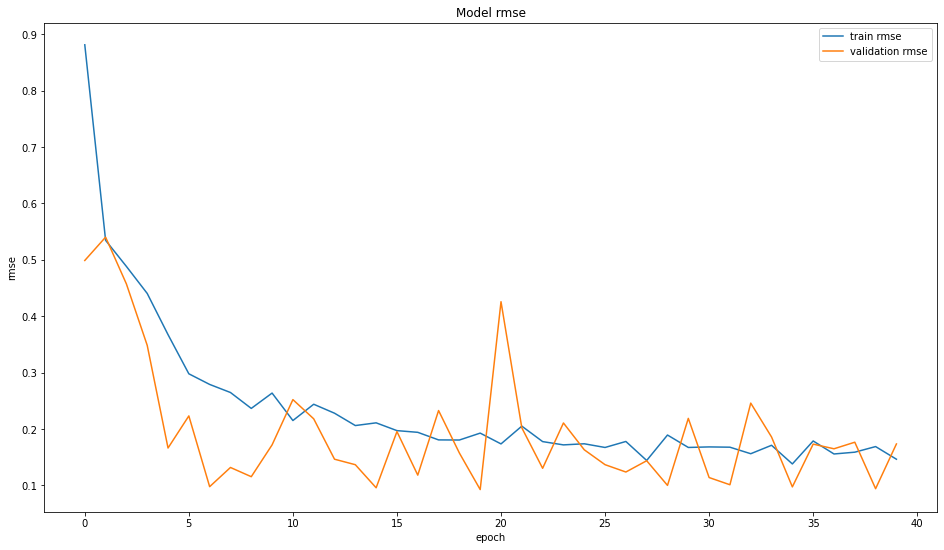

In [32]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

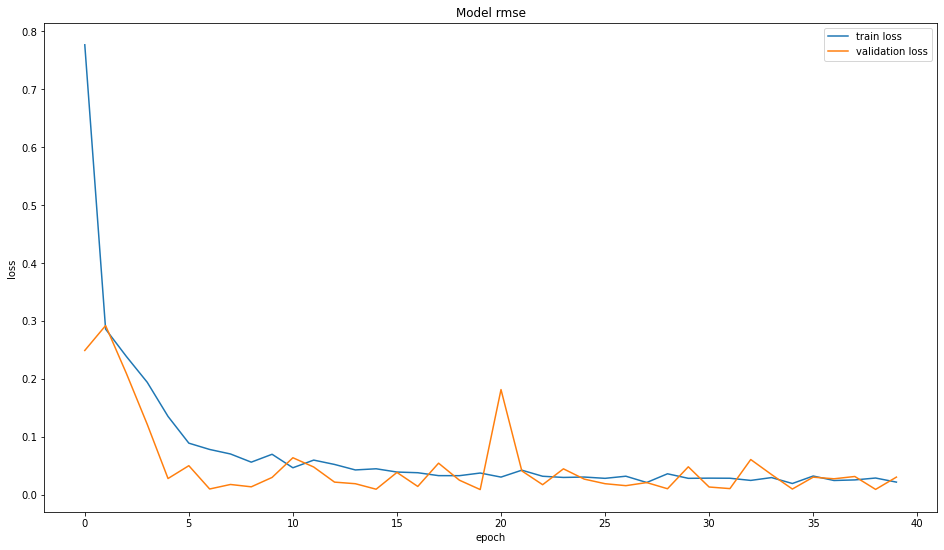

In [33]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model rmse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()